<a href="https://colab.research.google.com/github/ElenaMorozzova/NLP_Intro/blob/main/NLP_DZ7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving summer_reviews.xls to summer_reviews.xls


In [1]:
import pandas as pd
data =pd.read_excel('summer_reviews.xls')
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [2]:
data['Content'] = data['Content'].astype('str') 
data['Rating'] = data['Rating'].astype('int') 

Предобработка текста

In [6]:
# !pip install pymorphy2

from string import punctuation
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import re

In [7]:
import nltk
# nltk.download('stopwords')

In [8]:
sw = set(stopwords.words("russian"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

data['Content_1'] = data['Content'].apply(preprocess_text)

In [9]:
data.head(30)

,Rating,Content,Date,Content_1
0,5,It just works!,2017-08-14,it just works
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложениеиз минус хотеть слиш...
2,5,Отлично все,2017-08-14,отлично
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать 1 работа антивирус далёкий нику...
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро
5,5,Всё удобно норм 👍👍👍,2017-08-14,всё удобно норма 👍👍👍
6,5,Очень удобное приложение.,2017-08-14,очень удобный приложение
7,5,Все устраивает,2017-08-14,устраивать
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,работать чётко отличие банкомат который вечно ...
9,5,Очень все хорошо👍,2017-08-14,очень хорошо👍


In [10]:
from nltk.tokenize import word_tokenize
# nltk.download("punkt")

train_corpus = " ".join(data["Content_1"])
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)

In [11]:
from nltk.probability import FreqDist

max_words = 200
tokens_filtered = [word for word in tokens if word.isalnum()]

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
tokens_filtered_top[:10]

['приложение',
 'очень',
 'удобно',
 'работать',
 'удобный',
 'всё',
 'отлично',
 'спасибо',
 'нравиться',
 'хороший']

In [12]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [13]:
from collections import Counter
words_counter = Counter((word for text in data.Content_1 for word in text.split()))

vocabulary = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 3:
        break
        
    vocabulary[word] = len(vocabulary)
    
print('Words count', len(vocabulary))

Words count 3188


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.Content_1, data.Rating, test_size=0.3, random_state=42)

In [15]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [16]:
def convert(texts, vocabulary, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in vocabulary:
                result.append(vocabulary[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

max_len = 40
X_train = convert(X_train, vocabulary, max_len)
X_test = convert(X_test, vocabulary, max_len)

In [17]:
X_test

array([[   0,    0,    0, ...,    0,    7,    8],
       [   0,    0,    0, ...,    4,  580, 1370],
       [   0,    0,    0, ...,   83,   16,   65],
       ...,
       [   0,    0,    0, ...,  338, 1300,   95],
       [   0,    0,    0, ...,  143,   79,  270],
       [   0,    0,    0, ...,    0,    0,    0]])

Строим сеть для классификации отзывов, есть перекос в данных в сторону высокого рейтинга (5) - таких 71% наблюдений

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train) 
y_test = le.transform(y_test)

In [19]:
X_train.shape, y_train.shape

((14461, 40), (14461,))

In [24]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping 

In [20]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

In [22]:
import tensorflow.keras.layers as L
from tensorflow.keras import Model, Sequential

dim = int(len(vocabulary)**(1/2))
num_classes = len(data.Rating.unique())
inputs = L.Input(shape=(X_train.shape[1],))

model = Sequential()
model.add(L.Embedding(input_dim=len(vocabulary), output_dim=dim, input_length=max_len))
model.add(L.Conv1D(128, 3))
model.add(L.Bidirectional(L.LSTM(units=32, return_sequences=True, activation="relu")))
model.add(L.GlobalMaxPool1D())
model.add(L.Dense(32, activation="relu"))
model.add(L.Dense(num_classes, activation="softmax"))

In [23]:
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 56)            178528    
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           21632     
                                                                 
 bidirectional (Bidirectiona  (None, 38, 64)           41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 1

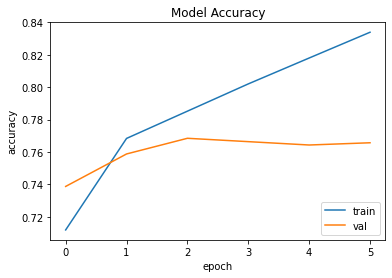

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=10, 
          validation_split=0.1, callbacks=[callback], verbose=0)
plot_history(history)

In [25]:
model.evaluate(X_test, y_test)

194/194 [==============================] - 2s 12ms/step - loss: 0.6401 - accuracy: 0.7785


[0.6401196122169495, 0.7784769535064697]

2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/

2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию

In [12]:
# !pip install wget
# !pip install gensim
import numpy as np
import wget
import sys
import gensim

In [4]:
import zipfile

# скачаем новейшую модель для русского языка, созданную на основе Национального корпуса русского языка (НКРЯ)
model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    ru_emb = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [14]:
def code_w2v_txt(txt, max_len = 100):
    sent_w2v = []
    zero_point = np.zeros(300)
    txt = txt.split()
   
    for i in range(max_len):
        try:
            word = ru_emb[txt[i]]
        except:
            word = zero_point
        sent_w2v.append(word)
    return np.array(sent_w2v)

max_len = 40
data['w2v'] = data['Content_1'].apply(code_w2v_txt, max_len = max_len)

In [15]:
data.head()

,Rating,Content,Date,Content_1,w2v
0,5,It just works!,2017-08-14,it just works,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложениеиз минус хотеть слиш...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,5,Отлично все,2017-08-14,отлично,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать 1 работа антивирус далёкий нику...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [16]:
X=np.array(list(data['w2v'].values))
y = data['Rating'].values

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train) 
y_test = le.transform(y_test)

In [22]:
import tensorflow.keras.layers as L
from tensorflow.keras import Model, Sequential

num_classes = len(data.Rating.unique())
# Строим точно такую же модель на предобученных векторах
model = Sequential()
model.add(L.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(L.Conv1D(128, 3))
model.add(L.Bidirectional(L.LSTM(units=32, return_sequences=True, activation="relu")))
model.add(L.GlobalMaxPool1D())
model.add(L.Dense(32, activation="relu"))
model.add(L.Dense(num_classes, activation="softmax"))

In [25]:
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 128)           115328    
                                                                 
 bidirectional (Bidirectiona  (None, 38, 64)           41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 158,789
Trainable params: 158,789
Non-trai

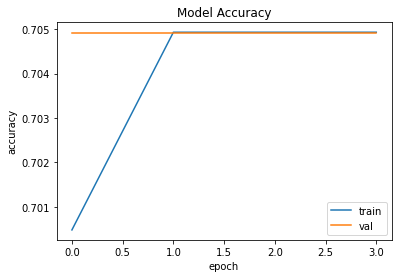

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=10, 
          validation_split=0.1, callbacks=[callback], verbose=0)
plot_history(history)

In [27]:
# Точность на тесте получилась ниже, чем в исходной модели, именно в этой задаче подход с использованием слоя EMBEDDING показал себя несколько лучше чем предобученный W2V
model.evaluate(X_test, y_test)

194/194 [==============================] - 4s 20ms/step - loss: 1.5101 - accuracy: 0.7086


[1.5100911855697632, 0.7086156606674194]